In [35]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
import warnings
import json
from scorer import ScorerInfo
from pathlib import Path
from collections import defaultdict
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "is_sparse")

path_to_base = Path('/home/nikgr')

In [36]:
calcs = {'auROC': ScorerInfo("prroc_rocauc", "rocauc").make(),
         'auPRC': ScorerInfo("prroc_prauc", "prauc", params={"type": "integral"}).make()}

In [37]:
# run_name, model_name, version = 'mex_models_prod/finalize_run', 'CREB3L3-CHS-GHTS-3', 0
# run_name, model_name, version = 'mex_models_prod/finalize_run', 'ZNF772-CHS-GHTS-2', 0
run_name, model_name, version = 'mex_models/inf_cont_testing_1000', 'ZNF131-CHS-GHTS', 0

# run_name, model_name, version = 'mex_models/more_epochs', 'ZNF226-CHS-GHTS', 0
# run_name, model_name, version = 'mex_models/more_epochs', 'ZNF226-GHTS-CHS', 0

In [38]:
path_to_model = path_to_base / run_name / model_name
path_to_metrics = path_to_model / ('model/lightning_logs/version_%d/metrics.csv' % version)
path_to_preds = path_to_model / 'model' #'/model/predictions_new_format.tsv'
path_to_conf = path_to_model / 'config.json'
model_full_descr = 'LegNet (%s)' % (model_name)

In [39]:
print(path_to_conf)
with open(path_to_conf) as f:
    model_config = json.load(f)
print(model_config)

/home/nikgr/mex_models/inf_cont_testing_10000/ZNF131-CHS-GHTS/config.json
{'stem_ch': 80, 'stem_ks': 40, 'ef_ks': 9, 'ef_block_sizes': [80, 96, 112, 128], 'resize_factor': 4, 'pool_sizes': [2, 2, 2, 2], 'reverse_augment': True, 'use_reverse_channel': False, 'use_shift': True, 'max_shift': [25, 25], 'max_lr': 0.0025, 'weight_decay': 0.1, 'model_dir': '/home/nikgr/mex_models/inf_cont_testing/ZNF131-CHS-GHTS', 'train_path': '/home/nikgr/MEX/DATASETS/CHS/Train/ZNF131', 'ref_genome_path': '/home/nikgr/hg38/hg38.fa', 'valid_path': '/home/nikgr/MEX/DATASETS/CHS/Test/ZNF131', 'test_path': '/home/nikgr/MEX/DATASETS/GHTS/Test/ZNF131', 'epoch_num': 10, 'device': 0, 'seed': 777, 'train_batch_size': 1024, 'valid_batch_size': 1024, 'num_workers': 24, 'training': True, 'negatives': 'random', 'negatives_test': 'foreigns', 'pwms_path': '/home/nikgr/MEX/best_20_motif_CHS_GHTS/CHS/ZNF131', 'pwms_freeze': False, 'pwm_loc': 'edge', 'model_type': 'LegNet'}


In [40]:
def get_mod_info(conf):
    aug = []
    if conf['reverse_augment']:
        aug.append('rev')
    if conf['use_shift']:
        # aug.append(f'{conf["max_shift"][0]}-{conf["max_shift"][1]} shift')
        aug.append(f'{conf["max_shift"][0]} shift')
    if len(aug) == 0:
        aug.append('w/o aug')
    else:
        aug[0] = 'with ' + aug[0]
        aug[-1] = aug[-1] + ' aug'
    aug = ' & '.join(aug)
    neg = conf['negatives'] + ' neg.'
    ep_n = f'{conf["epoch_num"]} ep.'
    inter = '' if conf['pwms_path'] is None else '&PWMs '
    return f'{conf["model_type"]} ' + inter + ', '.join([aug, neg, ep_n])

def get_run_info(conf):
    train_split = conf["train_path"].split("/")
    return f'{train_split[-1]} {train_split[-3]}/{conf["test_path"].split("/")[-3]}'

mod_info = get_mod_info(model_config)
run_info = get_run_info(model_config)
print(mod_info)
print(run_info)

LegNet &PWMs with rev & 25 shift aug, random neg., 10 ep.
ZNF131 CHS/GHTS


In [41]:
metrics_df = pd.read_csv(path_to_metrics, sep=',')
left_df = metrics_df[['val_loss', 'val_auroc', 'epoch', 'step']].dropna()
right_df = metrics_df[['epoch', 'step', 'train_loss', 'train_add_loss', 'train_sum_loss']].dropna()
metrics_df = pd.merge(left_df, right_df, on=['epoch', 'step'])
metrics_df.tail()

,val_loss,val_auroc,epoch,step,train_loss,train_add_loss,train_sum_loss
5,0.023058,0.974027,5,5207,0.023122,0.000021,0.023143
6,0.022783,0.974872,6,6075,0.021956,0.000019,0.021975
7,0.021530,0.978091,7,6943,0.021012,0.000019,0.021031
8,0.021539,0.978169,8,7811,0.020178,0.000019,0.020197
9,0.020957,0.978634,9,8679,0.019647,0.000019,0.019666


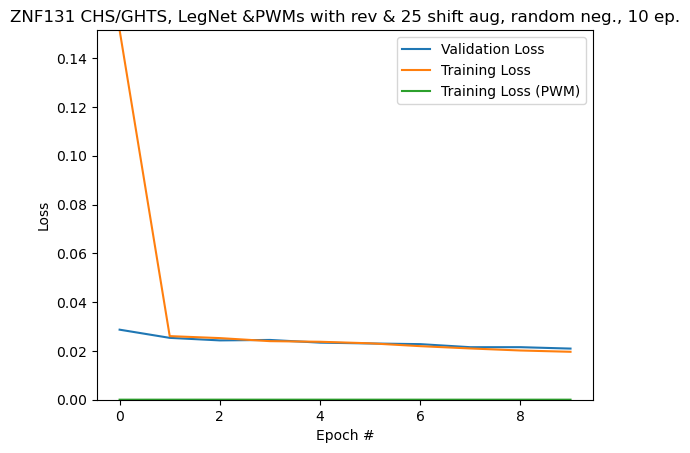

In [42]:
ax = plt.axes()
ax.set_ylim(0, max(metrics_df['val_loss'].max(), metrics_df['train_loss'].max()))
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss')
plt.plot(metrics_df['epoch'], metrics_df['train_add_loss'], label='Training Loss (PWM)')
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(loc='upper right')
plt.show()


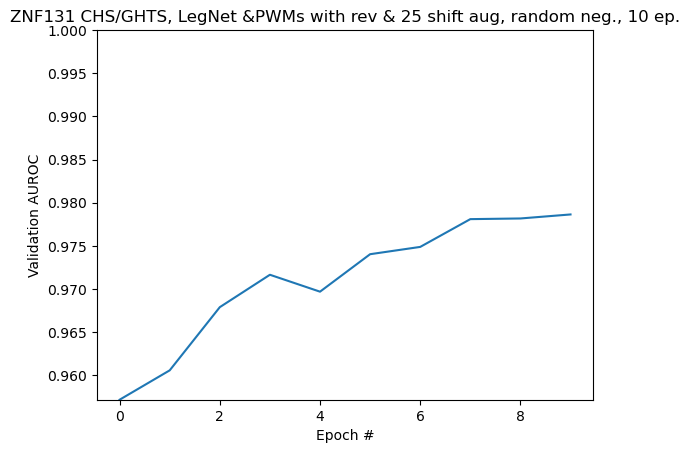

In [43]:
ax = plt.axes()
ax.set_ylim(metrics_df['val_auroc'].min(), 1)
# ax.set_ylim(0.8, 1)
plt.plot(metrics_df['epoch'], metrics_df['val_auroc'])
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Validation AUROC')
plt.xlabel('Epoch #')
plt.show()

In [44]:
preds = ('forw_pred', 'avg_pred', 'rev_pred')
preds_names = {'forw_pred': 'forward', 'rev_pred': 'reverse', 'avg_pred': 'averaged'}
def process_preds_df(path, split, old=False):
    preds_df = pd.read_csv(path % split if not old else path, sep='\t')
    preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
    return preds_df

In [45]:
def process_multitesting_preds_df(path):
    if isinstance(path, str):
        path = Path(path)
    files = path.rglob('*.tsv')
    for file in files:
        if 'predictions' not in file.stem:
            continue
        name_components = file.stem.split('_')
        preds_df = pd.read_csv(file, sep='\t')
        preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
        yield (preds_df, name_components[3], name_components[4])

In [46]:
def plot_roc(preds_df, split, negative='', ax=None, title=None, correct=True):
    ax_wasnt_set = ax is None
    ax = plt.axes() if ax_wasnt_set else ax
    ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    title = f'ROC on {run_info}, {mod_info} [{split} {negative}]' if title is None else title
    ax.set_title(title)
    
    output = None
    for pred in preds:
        fpr, tpr, _ = metrics.roc_curve(preds_df['class_'], preds_df[pred])
        auc = metrics.roc_auc_score(preds_df['class_'], preds_df[pred])
        if correct:
            auc = calcs['auROC'].score(preds_df[pred], preds_df['class_'])
            print('ROC', pred, auc)

        ax.plot(fpr, tpr, label=f'{preds_names[pred]}, AUC = {auc:.3}')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
        output = auc if pred == 'avg_pred' else output 
    if ax_wasnt_set:
        plt.show()
    return output
    
def plot_pr(preds_df, split, negative='', ax=None, title=None, correct=True):
    ax_wasnt_set = ax is None
    ax = plt.axes() if ax_wasnt_set else ax
    # ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    title = f'PR on {run_info}, {mod_info} [{split} {negative}]' if title is None else title
    ax.set_title(title)
     
    output = None
    for pred in preds:
        precision, recall, _ = metrics.precision_recall_curve(preds_df['class_'], preds_df[pred])
        pr = metrics.average_precision_score(preds_df['class_'], preds_df[pred])
        if correct:
            pr = calcs['auPRC'].score(preds_df[pred], preds_df['class_'])
            print('PR', pred, pr)

        ax.plot(recall, precision, label=f'{preds_names[pred]}, PR = {pr:.3}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower right')
        output = pr if pred == 'avg_pred' else output 
    if ax_wasnt_set:
        plt.show()
    return output

In [47]:
try:
    for split in ('valid', 'test'):
        print(f'{split:-^86s}')
        preds_df = process_preds_df(path_to_preds, split)
        plot_roc(preds_df, split)
        plot_pr(preds_df, split)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split}]')
        plt.show()
        print('')
except:
    pass  
        

----------------------------------------valid-----------------------------------------


In [48]:
try:
    for split in ('test',):
        print(f'{split:-^86s}')
        preds_df = process_preds_df(path_to_preds, split, old=True)
        plot_roc(preds_df, split)
        plot_pr(preds_df, split)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split}]')
        plt.show()
        print('')
except:
    pass  

-----------------------------------------test-----------------------------------------


[column names on plot](https://stackoverflow.com/questions/45758761/adding-title-to-the-column-of-subplot-below-suptitle)

*************cross***************************random*************

*************inside*************************foreigns************

*************inside**************************shades*************

*************cross***************************shades*************

*************inside**************************random*************

*************cross**************************foreigns************



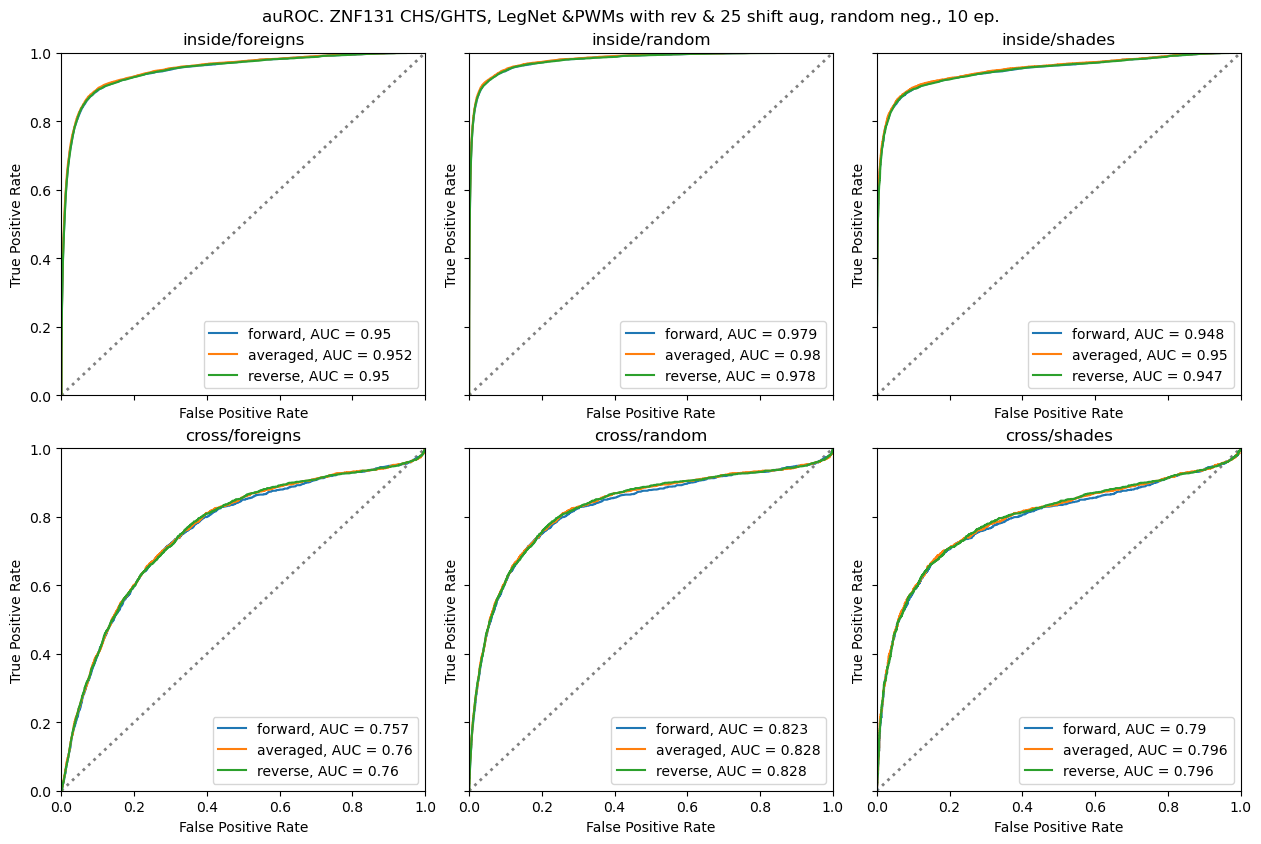

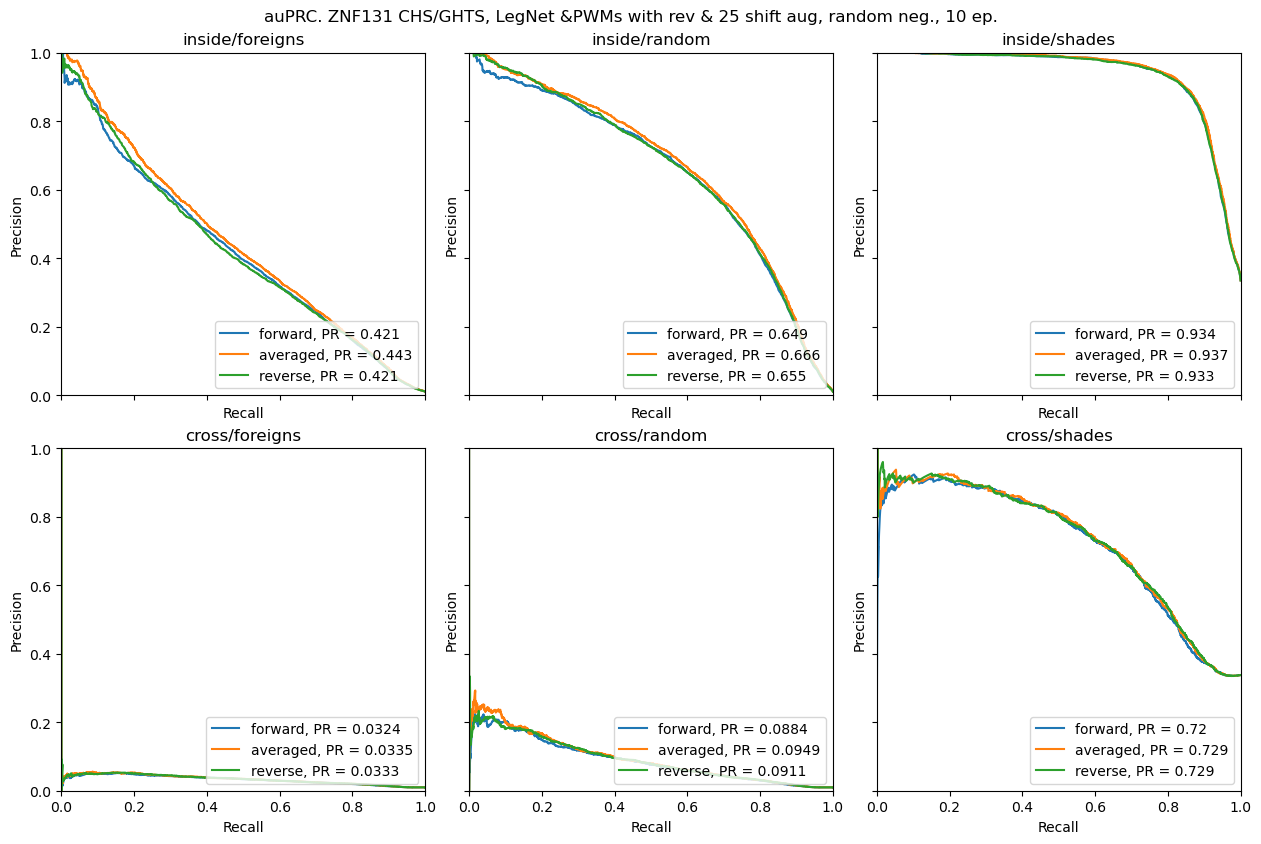

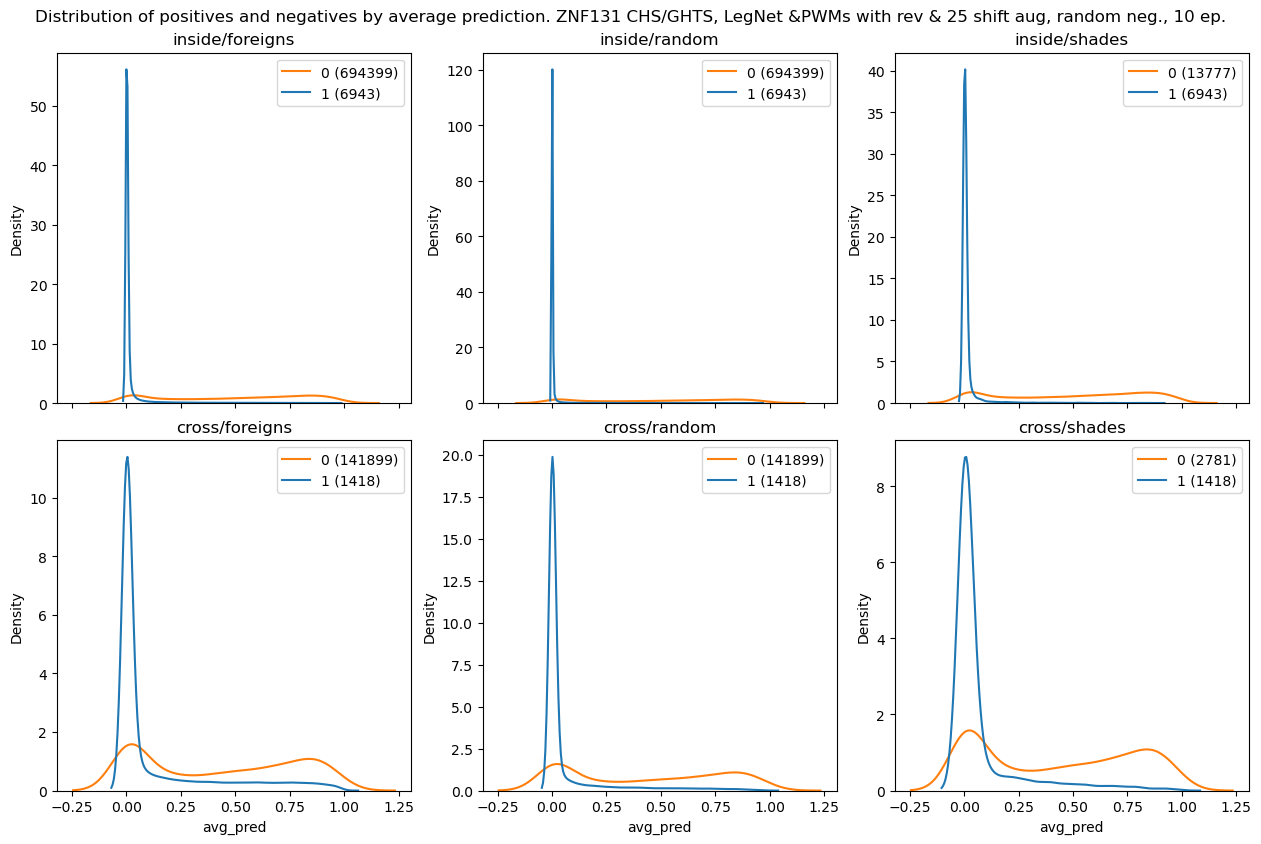

In [49]:
figsize = [x / 1.2 for x in (15, 10)]

fig_roc, axs_roc = plt.subplots(2, 3, figsize=figsize, layout='constrained',
                                sharex=True, sharey=True)
fig_roc.suptitle(f'auROC. {run_info}, {mod_info}')
fig_pr, axs_pr = plt.subplots(2, 3, figsize=figsize, layout='constrained',
                              sharex=True, sharey=True)
fig_pr.suptitle(f'auPRC. {run_info}, {mod_info}')
fig_distr, axs_distr = plt.subplots(2, 3, figsize=figsize, layout='constrained',
                                    sharex=True)
fig_distr.suptitle(f'Distribution of positives and negatives by average prediction. {run_info}, {mod_info}')
def get_ax(axs, split, negative):
    splits_int = {
        'inside': 0,
        'cross': 1
    }
    negatives_int = {
        'foreigns': 0,
        'random': 1,
        'shades': 2
    }
    split_int = splits_int[split]
    negative_int = negatives_int[negative]
    return axs[split_int, negative_int]

def get_title(split, negative):
    # return f'{split}-experiment, {negative} as negatives'
    return f'{split}/{negative}'

rocs = defaultdict(dict)
prs = defaultdict(dict)

try:
    for preds_df, split, negative in process_multitesting_preds_df(path_to_preds):
        print(f'{split:*^32s}{negative:*^32s}')
        roc = plot_roc(preds_df, split, negative, ax=get_ax(axs_roc, split, negative), title=get_title(split, negative), correct=False)
        pr = plot_pr(preds_df, split, negative, ax=get_ax(axs_pr, split, negative), title=get_title(split, negative), correct=False)
        rocs[split][negative] = roc
        prs[split][negative] = pr
        
        dist_ax = get_ax(axs_distr, split, negative)
        g = sns.kdeplot(preds_df, x="avg_pred", hue="class_", common_norm=False, ax=dist_ax)
        dist_ax.set_title(get_title(split, negative))
        dist_ax.legend(labels = [f'{x} ({n})' for x, n in preds_df['class_'].value_counts().items()])
        # plt.show()
        print('')
except Exception as ex:
    raise ex
plt.show()

In [50]:
rocs = pd.DataFrame(rocs).transpose()
rocs

,random,shades,foreigns
cross,0.827633,0.795709,0.760399
inside,0.979962,0.950015,0.951856


In [51]:
prs = pd.DataFrame(prs).transpose()
prs

,random,shades,foreigns
cross,0.094889,0.728522,0.033485
inside,0.666090,0.936930,0.442731
